## The Scenario
A hospital has struggled with "readmissions," where they release a patient before the patient has recovered enough, and the patient returns with health complications. 

The hospital wants your help identifying patients at highest risk of being readmitted. Doctors (rather than your model) will make the final decision about when to release each patient; but they hope your model will highlight issues the doctors should consider when releasing a patient.

The hospital has given you relevant patient medical information.  Here is a list of columns in the data:

In [1]:
# This file contains machine learning explainability problems, specifically SHAP values, to 
# refer back to when writing new code
import pandas as pd
data = pd.read_csv('data/train_1.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

- Your prediction target is `readmitted`
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.

## Step 1
You have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

We'll start after the point where you've built a basic model. Just run the following cell to build the model called `my_model`.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

Now use the following cell to create the materials for the doctors.

In [4]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

C:\Users\timmc\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\timmc\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


## Step 2

It appears `number_inpatient` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `num_inpatient` affects the model's predictions.

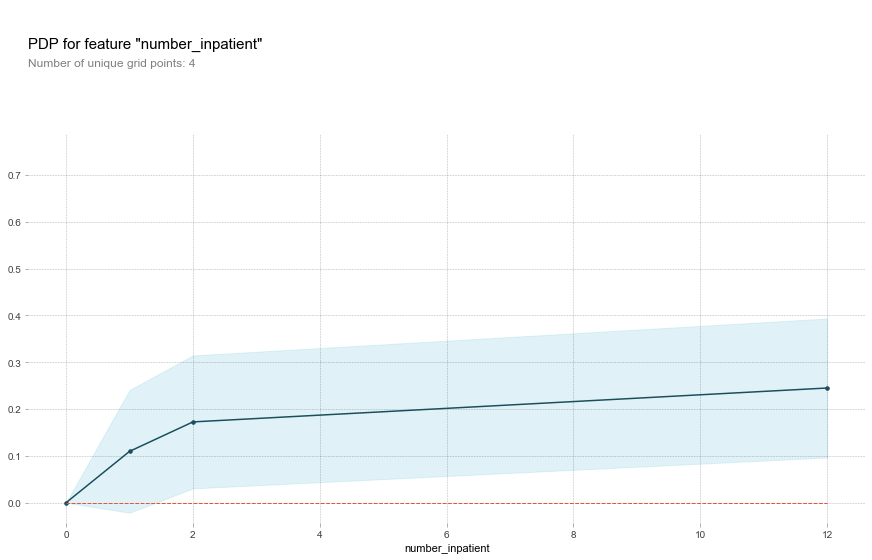

In [7]:
# PDP for number_inpatient feature

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'number_inpatient'
# Create the data that we will plot
my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

## Step 3

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions.  But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

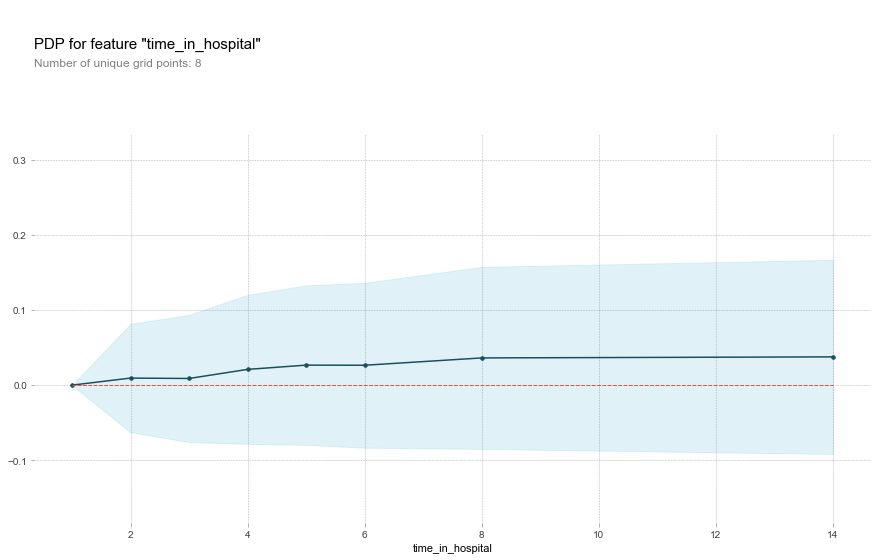

In [6]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'time_in_hospital'
# Create the data that we will plot
my_pdp = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=val_X.columns, feature=feature_name)

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

## Step 4

Woah!  It seems like `time_in_hospital` doesn't matter at all.  The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could  the data be wrong, or is your model doing something more complex than they expect?  

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot. 
- Are the results similar or different?

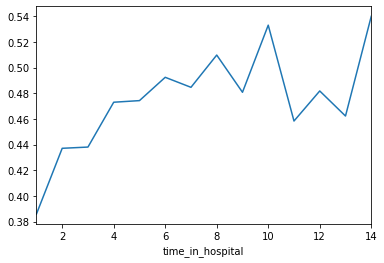

In [8]:
# A simple pandas groupby showing the average readmission rate for each time_in_hospital.

# Do concat to keep validation data separate, rather than using all original data
all_train = pd.concat([train_X, train_y], axis=1)

all_train.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

## Step 5
Now the doctors are convinced you have the right data, and the model overview looked reasonable.  It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following
- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk.  It's fine to focus on only the most important features for that patient.

In [9]:
# Use SHAP values to show the effect of each feature of a given patient

import shap  # package used to calculate Shap values

sample_data_for_prediction = val_X.iloc[0].astype(float)  # to test function

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)